In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np

import sys
sys.path.append("../..")

from neuroprob import stats, tools, neural_utils
import neuroprob.models as mdl

dev = tools.PyTorch()


from tqdm.autonotebook import tqdm


plt.style.use(['paper.mplstyle'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
PyTorch version: 1.6.0+cu101
Using device: cuda:0


In [ ]:
# Dethroning the Fano factor
f_modes = ['exp', 'rect_quad', 'softplus']

T = 10
trials = 1000000
sample_bin = 1.0

### Count process and segment length
sigma_n = .1
a_arr = [np.linspace(-1.0, 1.5, 10), np.linspace(-1.0, 3.5, 10), np.linspace(0.0, 5.5, 10)]
    
FF = []
T_DS = []
SPM = []
for m, f_mode in enumerate(f_modes):
    print(f_mode)
    
    FF_ = []
    T_DS_ = []
    SPM_ = []
    for a in a_arr[m]:
        print(a)
        #rate = np.empty((T*trials))
        noise = sigma_n*np.random.randn(trials).repeat(T)
        if f_mode == 'exp':
            rate = np.exp(noise + a)

        elif f_mode == 'softplus':
            rate = np.log(1. + np.exp(noise + a))
            
        elif f_mode == 'rect_quad':
            rate = (noise + a)
            rate[rate < 0] = 0
            rate = rate**2
            
        elif f_mode == 'relu':
            rate = noise + a
            rate[rate < 0] = 0

        else:
            raise ValueError


        # generating spike trains
        train = mdl.point_process.gen_IPP(rate, sample_bin, max_count=100)

        # fitting with Poisson ML i.e. average rate
        act = train.reshape(trials, T).sum(-1)
        #rate_model = act.repeat(T)
        rate_model = train.mean()[None].repeat(trials*T)/sample_bin

        f_p = lambda c, avg, shape, t: stats.poiss_count_prob(c, avg, shape, t)
        m_f = lambda x: x
        cnt_tuple = stats.count_KS_method(f_p, m_f, sample_bin, train, rate_model, \
                                          T, min_spikes=0)
        q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS, traj_lens = cnt_tuple
        T_DS_.append(Z_DS)
        FF_.append(act.var()/act.mean())
        SPM_.append(act.mean())
    
    T_DS.append(T_DS_)
    FF.append(FF_)
    SPM.append(SPM_)
    
T_DS = np.array(T_DS)
FF = np.array(FF)
SPM = np.array(SPM)

### T_DS metric sampling distribution and Fano factor

In [133]:
def pick_segments(spktrain, rate_model, shape_model, tbin, traj_len=None, traj_spikes=None):
    """
    Pick segments either with fixed length or fixed spike counts.
    
    When the segment length is bigger than 1, we add the rates and the activity in a bin 
    and take the mean shape.
    
    traj_len = None means we select on fixed spike counts, traj_spikes = None means we 
    select on fixed bin lengths.
    """
    T = rate_model.shape[0]
    
    if shape_model is not None:
        assert traj_len == 1
        
    traj_lens = []
    if traj_len is not None:
        traj_lens = (T // traj_len) * [traj_len]
    
    if traj_spikes is not None:
        avg_spikecnt = np.cumsum(rate_model*tbin)
        nc = 1
        traj_len = 0
        for tt in range(T):
            if avg_spikecnt >= traj_spikes*nc:
                nc += 1
                traj_lens.append(traj_len)
                traj_len = 0
                continue
            traj_len += 1

    if shape_model is not None:
        sh = shape_model
        spktr = spktrain
        rm = rate_model
        
    else:
        sh = None
        spktr = []
        rm = []
        start = np.cumsum(traj_lens)
        for tt, traj_len in enumerate(traj_lens):
            spktr.append(spktrain[start[tt]:start[tt]+traj_len].sum())
            rm.append(rate_model[start[tt]:start[tt]+traj_len].sum())
        spktr = np.array(spktr)
        rm = np.array(rm)
        
    return rm, spktr, sh, traj_lens

In [170]:
# normality of the metric
sample_bin = 0.001
sZ_DS_ = []
sZ_DS__ = []

for sim_samples in [10000]:

    Z_DS_ = []
    Z_DS__ = []
    for k in range(10000): # Poisson
        rate_ = np.empty((1, sim_samples))
        rate_.fill(10.0)

        train = mdl.point_process.gen_IPP(rate_, sample_bin)
        spikes = neural_utils.BinToTrain(train[0])

        traj_len = 1000
        rate, train, shape, traj_lens = pick_segments(train[0], rate_[0], None, sample_bin, traj_len=traj_len)
        
        f_p = lambda c, avg, shape, t: stats.poiss_count_prob(c, avg, shape, t)
        m_f = lambda x: x
        quantiles = stats.count_KS_method(f_p, m_f, sample_bin, train, rate, shape=shape)
        cnt_tuple = stats.KS_statistics(quantiles, alpha=0.05, alpha_s=0.05)

        T_DS, T_KS, s_DS, s_KS, p_DS, p_KS = cnt_tuple
        Z_DS_.append(T_DS)

        dist_isi = mdl.point_process.ISI_gamma(1.0)
        quantiles = stats.ISI_KS_method(dist_isi, sample_bin, spikes, rate_[0])
        isi_tuple = stats.KS_statistics(quantiles, alpha=0.05, alpha_s=0.05)

        T_DS, T_KS, s_DS, s_KS, p_DS, p_KS = isi_tuple
        Z_DS__.append(T_DS)
        
    sZ_DS_.append(Z_DS_)
    sZ_DS__.append(Z_DS__)
    
Z_DS_ = np.array(sZ_DS_)
Z_DS__ = np.array(sZ_DS__)

In [90]:
sample_bin = 5.
neurons = 1

VI_tuples = [(None, None, None, 1)]

glm_rate = mdl.parametrics.GLM(neurons, 1, 1, 'relu', VI_tuples, bias=True)
glm_rate.set_params(sample_bin, w=np.ones((neurons, 1)))

# NB process output
r_inv = 1.0*np.ones(neurons)
#alpha = 0.2*np.ones(neurons)
likelihood = mdl.likelihoods.Negative_binomial(neurons, 'relu', r_inv)
#likelihood = mdl.likelihoods.ZI_Poisson(neurons, 'exp', alpha)
likelihood.set_params(sample_bin)

# NLL model
hist_len = 1
glm = mdl.inference.nll_optimized([glm_rate], likelihood, dispersion_model=None)
#glm.to(dev)


spike_samples = 0
trials = 1000
time_steps = 1
ini_train = np.zeros((trials, neurons, 1))

cnts = []

mus = np.linspace(0, 10, 101)
for amp in mus:
    rate = torch.ones(trials, neurons, time_steps)*amp
    syn_train = likelihood.sample(rate, np.arange(neurons), disp=None, max_count=1000)
    cnts.append(syn_train[:, 0, 0])
    
cnts = np.array(cnts)

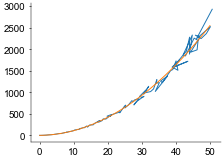

In [121]:
plt.plot(cnts.mean(-1), cnts.var(-1))

# exact relation
mus_ = mus*5
ff = mus_*(1+mus_*r_inv[0])
plt.plot(mus_, ff)

10000


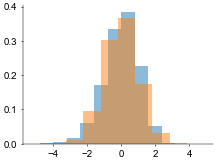

In [179]:
gsamp = np.random.randn(1000000)
plt.hist(Z_DS_[0], density=True, alpha=0.5)
plt.hist(gsamp, density=True, alpha=0.5)
print(len(Z_DS_[0]))

In [173]:
# negative binomial
np.exp(-10)

4.5399929762484854e-05

In [122]:
def fit_likelihood(mode, sample_bin, train, sim_samples, lr=1e-2, neurons=1):
    """
    fit ML of homogeneous rate
    """
    if mode == 'gamma':
        shape = 1.0*np.ones(neurons)
        likelihood = mdl.likelihoods.Gamma(neurons, 'exp', # inverse link
                                           shape, # shape parameters of Gamma process
                                           dequantize=True, # add noise to the spike times when fitting
                                           allow_duplicate=False) # when > 1 spikes per bin, don't treat as single spike
        
    elif mode == 'NB':
        r_inv = 10.*np.ones(neurons)
        likelihood = mdl.likelihoods.Negative_binomial(neurons, 'exp', r_inv) # when > 1 spikes per bin, don't treat as single spike
        
    likelihood.set_params(sample_bin)
    likelihood.preprocess(train, sim_samples)
    likelihood.to(dev) # move to device

    inner = Parameter(torch.tensor(np.log(10.0), device=dev)) # fit a single rate value

    tracked_loss = []
    minloss = np.inf
    epochs = 1000
    cnt = 0
    iterator = tqdm(range(epochs))
    optimizer = optim.SGD([inner], lr=1e-12)
    for epoch in iterator:
        sloss = 0

        optimizer.zero_grad()
        loss = renewal_dist.nll(inner.expand((1, 1, sim_samples)), 0, 0, [0])
        loss.backward()
        optimizer.step()

        assert not torch.isnan(loss.data).any()
        sloss += loss.item()

        iterator.set_postfix(loss=sloss)
        tracked_loss.append(sloss)
        if sloss < minloss:
            minloss = sloss
            cnt = 0
        else:
            cnt += 1

    plt.plot(tracked_loss)
    
    if mode == 'gamma':
        shape = likelihood.shape.data.cpu().numpy()
    elif mode == 'NB':
        shape = likelihood.r_inv.shape.data.cpu().numpy()

    rate_fit = np.exp(inner.item())
    return rate_fit, shape

In [112]:
### generate plotting data
rate = np.empty((1, 1, sim_samples))
sim_samples = 500000
sample_bin = 0.001


# Poisson
rate.fill(10.0)
train_P = mdl.point_process.gen_IPP(rate, sample_bin)
spikes_P = neural_utils.BinToTrain(train_P[0, 0, :])
    

# Gamma overdispersed
rate.fill(5.0)
shape = np.array([.5])
renew = mdl.point_process.ISI_gamma(shape)
spikes_GO = mdl.point_process.gen_IRP(renew, rate, sample_bin)
_, _, train_GO, _ = neural_utils.BinTrain(1, sample_bin, spikes_GO, sim_samples)
    

# Gamma underdispersed
rate.fill(20.0)
shape = np.array([2.])
renew = mdl.point_process.ISI_gamma(shape)
spikes_GU = mdl.point_process.gen_IRP(renew, rate, sample_bin)
_, _, train_GU, _ = neural_utils.BinTrain(1, sample_bin, spikes_GU, sim_samples)


In [ ]:
isi_tuples = []
cnt_tuples = []
Z_cnt_values = []
Z_isi_values = []

for d in [(train_P, spikes_P), (train_GO, spikes_GO), (train_GU, spikes_GU)]:
    
    ### fit a Poisson model ###
    train, spikes = d
    
    rate_ML = train[0].sum()/sim_samples/sample_bin
    quantiles = count_KS_method(interval_dist, sample_bin, spike_ind, rate)
    Z_cnt_values.append(q_to_Z(quantiles, LIM=1e-15))
    
    shape_model = None
    f_p = lambda c, avg, t: stats.gamma_count_prob(c, avg, shape, t)
    m_f = lambda x: x
    quantiles = stats.count_KS_method(f_p, m_f, sample_bin, train, rate_ML, shape=sh)
    Z_values.append(q_to_Z(quantiles, LIM=1e-15))
    cnt_tuples.appen(stats.KS_statistics(quantiles, alpha=0.05, alpha_s=0.05))

    
    dist_isi = mdl.point_process.ISI_gamma(1.0)
    quantiles = stats.ISI_KS_method(interval_dist, sample_bin, spike_ind, rate)
    Z_isi_values.append(q_to_Z(quantiles, LIM=1e-15))
    isi_tuples.append(stats.KS_statistics(dist_isi, sample_bin, spikes, rate[0]))


    rate_fit, shape = fit_gamma(sample_bin, train, sim_samples)

    shape_model = None
    f_p = lambda c, avg, t: stats.gamma_count_prob(c, avg, shape, t)
    m_f = lambda x: x
    quantiles = stats.count_KS_method(f_p, m_f, sample_bin, train, rate_ML, shape=sh)
    Z_values.append(q_to_Z(quantiles, LIM=1e-15))
    cnt_tuples.appen(stats.KS_statistics(quantiles, alpha=0.05, alpha_s=0.05))

    
    dist_isi = mdl.point_process.ISI_gamma(1.0)
    quantiles = stats.ISI_KS_method(interval_dist, sample_bin, spike_ind, rate)
    Z_isi_values.append(q_to_Z(quantiles, LIM=1e-15))
    isi_tuples.append(stats.KS_statistics(dist_isi, sample_bin, spikes, rate[0]))



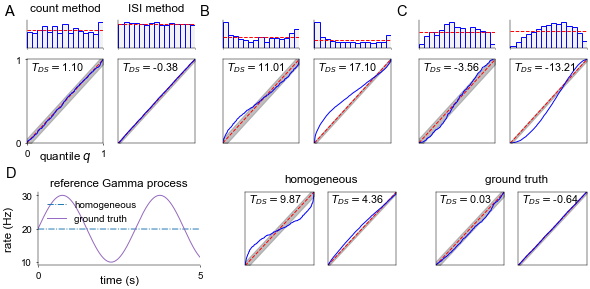

In [394]:
pickle.dump((cnt_tuples, isi_tuples, Z_cnt_values, Z_isi_values), open('./output/metric1.p', 'wb'))

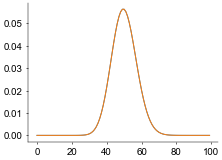

In [119]:
c = np.arange(100)
t = 1.0
avg = 50.0
shape = 1.0

pr = stats.gamma_count_prob(c, avg, shape, t)
pr2 = stats.poiss_count_prob(c, avg, shape, t)

plt.plot(c, pr)
plt.plot(c, pr2)

### Dispersion properties with modulation

In [ ]:
# modulation
rate = np.empty((1, sim_samples))

rate_0 = 20.0
mod = 10.0
period = 3000
for t in range(sim_samples):
    rate[0, t] = mod*np.sin(2*np.pi*t/period) + rate_0

shape = 2.0

renew = mdl.point_process.ISI_gamma(shape)
spikes = mdl.point_process.gen_IRP(renew, rate, sample_bin)
_, _, train, _ = neural_utils.BinTrain(1, sample_bin, spikes, sim_samples)


### fit ML of homogeneous rate ###
shape = 2.0
shape_t = shape*np.ones(1) # true shape parameters

# renewal process model
renewal_dist = mdl.likelihoods.Gamma(1, # neurons
                                     'exp', # inverse link
                                     shape_t, # shape parameters of Gamma process
                                     dequantize=True, # add noise to the spike times when fitting
                                     allow_duplicate=False) # when > 1 spikes per bin, don't treat as single spike
renewal_dist.set_params(sample_bin)
renewal_dist.preprocess(train, sim_samples)
renewal_dist.to(dev) # move to device

inner = Parameter(torch.tensor(np.log(20.0), device=dev)) # fit a single rate value

tracked_loss = []
minloss = np.inf
epochs = 1000
cnt = 0
iterator = tqdm(range(epochs))
optimizer = optim.SGD([inner], lr=1e-12)
for epoch in iterator:
    sloss = 0
    
    optimizer.zero_grad()
    loss = renewal_dist.nll(inner.expand((1, 1, sim_samples)), 0, 0, [0])
    loss.backward()
    optimizer.step()

    assert not torch.isnan(loss.data).any()
    sloss += loss.item()

    iterator.set_postfix(loss=sloss)
    tracked_loss.append(sloss)
    if sloss < minloss:
        minloss = sloss
        cnt = 0
    else:
        cnt += 1
        
plt.plot(tracked_loss)

rate_fit = np.exp(inner.item())


traj_len = 1000
f_p = lambda c, avg, t: stats.gamma_count_prob(c, avg, t, shape)
m_f = lambda x: x/shape
cnt_tuple_4 = stats.count_KS_method(f_p, m_f, sample_bin, train[0], rate_fit*np.ones_like(rate[0]), \
                          traj_len, min_spikes=5, repeat=1)

dist_isi = mdl.point_process.ISI_gamma(shape)
isi_tuple_4 = stats.ISI_KS_method(dist_isi, sample_bin, spikes[0], rate_fit*np.ones_like(rate[0]))


### fit true rate ###
traj_len = 1000
cnt_tuple_5 = stats.count_KS_method(f_p, m_f, sample_bin, train[0], rate[0], \
                          traj_len, min_spikes=5, repeat=1)

dist_isi = mdl.point_process.ISI_gamma(shape)
isi_tuple_5 = stats.ISI_KS_method(dist_isi, sample_bin, spikes[0], rate[0])

In [30]:
sim_samples = 1000000
sample_bin = 0.001
rate_modes = ['oscillatory', 'HMM']



### Count process and segment length
trials = 10
rate_model = np.empty((sim_samples))
traj_len_arr = [1000, 1500, 2000, 2500, 3000, 3500,\
                4000, 4500, 5000, 5500, 6000, 6500, 7000,\
                7500, 8000, 8500, 9000, 9500, 10000]
    
scores_t = []
rate_ = []
conf_ = []
avg_len_ = []
for rate_mode in rate_modes:

    rate = np.empty((sim_samples))
    
    if rate_mode == 'oscillatory':
        rate_0 = 10.0
        mod = 4.0
        period = 4000
        for t in range(sim_samples):
            rate[t] = mod*np.sin(2*np.pi*t/period) + rate_0

    elif rate_mode == 'HMM':
        taus = np.random.exponential(1000.0, size=(10000,))
        tau = taus[0]
        cnt = 0
        rate_1 = 8.0
        rate_2 = 12.0
        ratez = rate_1
        for t in range(sim_samples):
            if t >= tau:
                ratez = (rate_1 if cnt % 2 == 0 else rate_2)
                cnt += 1
                tau += taus[cnt]
            rate[t] = ratez


    # generating spike trains
    rate = np.tile(rate[None, :], (trials, 1))
    train = mdl.point_process.gen_IPP(rate, sample_bin)

    scores = []
    conf = []
    avg_len = []
    for traj_len in traj_len_arr:
        t = []
        print(traj_len)
        
        for k in range(trials):
            # fitting with Poisson ML i.e. average rate
            rate_model.fill(train[k].sum()/sim_samples/sample_bin)

            f_p = lambda c, avg, t: stats.poiss_count_prob(c, avg, t)
            m_f = lambda x: x
            cnt_tuple = stats.count_KS_method(f_p, m_f, sample_bin, train[k], rate_model, \
                                              traj_len, min_spikes=5, repeat=1)
            q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS, traj_lens = cnt_tuple
            t.append([Z_DS, T_KS])

        scores.append(t)
        avg_len.append(traj_lens.mean()*sample_bin)
        conf.append(s_KS)

    scores_t.append(np.array(scores))
    rate_.append(rate[0])
    conf_.append(np.array(conf))
    avg_len_.append(avg_len)
    
scores_t = np.array(scores_t)
    
    
### Dispersion and modulation
mod_arr = np.arange(0,11)
traj_len = 3000
trials = 10

dist_isi = mdl.point_process.ISI_gamma(1.0)

# rate models (Cox processes and LVMs)
scores = []
samples_c = []
samples_i = []
q = []
for mod in mod_arr:
    print(mod)
    
    rate_0 = 10.0
    period = 2000
    rate = np.empty((sim_samples))
    for t in range(sim_samples):
        rate[t] = mod*np.sin(2*np.pi*t/period) + rate_0

    # generating spike trains
    rate = np.tile(rate[None, :], (trials, 1))
    train = mdl.point_process.gen_IPP(rate, sample_bin)
    t_spike = []
    for k in range(trials):
        t_spike.append(train[k].nonzero()[0])

    # get T_DS from both ISI and count, save number of samples
    t = []
    for k in range(trials):
        # fitting with Poisson ML i.e. average rate
        rate_model.fill(train[k].sum()/sim_samples/sample_bin)
        
        traj_len = 3000
        f_p = lambda c, avg, t: stats.poiss_count_prob(c, avg, t)
        m_f = lambda x: x
        cnt_tuple = stats.count_KS_method(f_p, m_f, sample_bin, train[k], rate_model, \
                                  traj_len, min_spikes=5, repeat=1)
        q_cdf_c, Z_DS_c, T_KS, s_DS, s_KS_c, p_DS, p_KS, _ = cnt_tuple
        
        dist_isi = mdl.point_process.ISI_gamma(1.0)
        isi_tuple = stats.ISI_KS_method(dist_isi, sample_bin, t_spike[k], rate_model)
        q_cdf_i, Z_DS_i, T_KS, s_DS, s_KS_i, p_DS, p_KS = isi_tuple
        
        t.append([Z_DS_c, Z_DS_i])
        
        if k == trials-1:
            q.append([q_cdf_c, s_KS_c, q_cdf_i, s_KS_i])
        
    scores.append(t)
    
scores_mod = np.array(scores)

1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
0
1
2
3
4
5
6
7
8
9
10


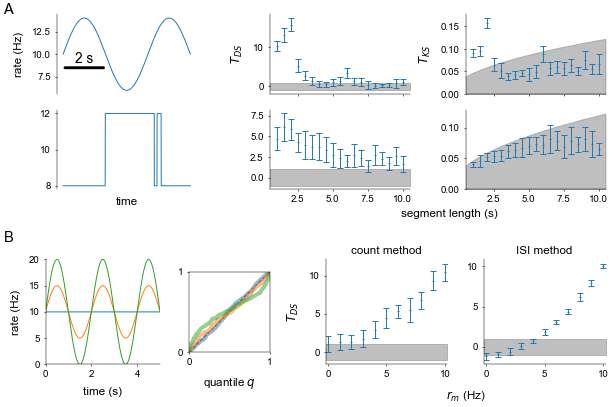